The data comes from the Kaggle Molecular Machine Learning competition: https://www.kaggle.com/competitions/molecular-machine-learning/data

The objective of this project is to predict the variable 'T80' given the other features in the dataset.

In [7]:
import pandas as pd
import numpy as np

In [8]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
display(train_df.head())
display(train_df.shape)

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,...,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,...,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,...,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,...,2.421162,2.703267,2.352276,1.595867,0.845839,0.354620,0.127878,0.060600,0.064782,0.098908
3,Train-04,71.88,O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21,372.470,4,0,5.9190,0.793825,4.948903,34.14,...,0.886320,0.579059,0.345148,0.246564,0.276259,0.381997,0.495304,0.566935,0.594203,0.614075
4,Train-05,68.37,CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...,457.620,5,0,8.5485,0.671148,5.994751,31.23,...,0.487723,0.245764,0.249019,0.363222,0.474953,0.505358,0.440671,0.330129,0.234649,0.183111


(42, 146)

Like most genomic data, we're dealing with a p > n situation, i.e. the number of features exceed the number of observations in the dataset. If we're not careful, it'll be very easy to overfit on the dataset. We'll have to do some major feature selection and engineering.

Potential techniques to try are:
- Lasso and Elastic Net Regression
- Bootstrap samples
- SVM


Let's first look at the string columns in the dataset, which appear to be just 'Smiles'

In [9]:
display(train_df.dtypes[train_df.dtypes == 'object'])

Batch_ID    object
Smiles      object
dtype: object

According to the Kaggle link, the SMILES variable is a text representation of the molecule. It'll be a challenge working with this data.

https://www.sciencedirect.com/science/article/pii/S2589004224003481

In [10]:
train_df['Smiles']

0                CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1
1                           CCCCCCCCCCCCc1ccsc1-c1cccs1
2     CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1
3        O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21
4     CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...
5     c1csc(-c2ccc(-c3ccc(-c4ccc5c(c4)C4(c6ccccc6Oc6...
6     CC(C)(C)OC(=O)CN1C(=O)CCc2cc(-c3ccc(-c4cccs4)s...
7         Cc1cc(-c2ccc(-c3ccc(-c4cccs4)s3)cc2)c2nnnn2c1
8     CCCCCCCCCCCCc1ccsc1-c1ccc(-c2ccc(-c3ccc(-c4ccc...
9     Cc1ccc(-c2ccc(-c3ccc(-c4cccs4)s3)cc2)cc1Cc1ccc...
10    CC(NC(=O)OC(C)(C)C)c1ccc(-c2ccc(-c3ccc(-c4cccs...
11    c1ccc([Si](c2ccccc2)(c2ccccc2)c2cccc(-c3ccc(-c...
12    CCCCC(CC)COc1c2cc(-c3ccc4oc(-c5ccc(N(c6ccccc6)...
13    CC(C)(C)c1ccc(-c2ccc(C(C)(C)C)cc2-c2cc3sc(-c4c...
14    Cc1ccc(NC(=O)OC(C)(C)C)cc1-c1cc2sc(-c3ccc(-c4c...
15    CCCCC(CC)COc1c2cc(-c3cccc(-c4c5ccccc5c(-c5cccc...
16    CCCCC(CC)COc1c2cc(-c3ccc4oc(-c5ccc6[nH]c(-c7cc...
17    c1ccc(C(c2ccccc2)(c2ccccc2)n2cnc(-c3ccc(-c

Playing around with RDKit, library/package/API/toolkit for working with molecules, including SMILE data.

Resources I looked at for this:
- https://xinhaoli74.github.io/posts/2020/04/RDKit-Cheatsheet/
- https://www.rdkit.org/docs/GettingStartedInPython.html
- https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles


In [11]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

You can pass in the SMILES string to the function to convert it to a mol type object. Calling it returns a visual representation of the molecule, which is really cool.

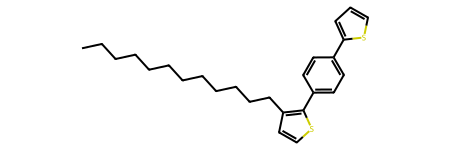

In [15]:
smiles = train_df['Smiles'][0]
mol = Chem.MolFromSmiles(smiles)
mol

You can further call a number of functions on the mol object, such as the number of atoms and bonds in the molecule. I think this might be our best bet of extracting some useful features for the problem.

In [18]:
display(mol.GetNumAtoms(), mol.GetNumBonds())

28

30